In [9]:
from kan import *
import pandas as pd
import torch
torch.set_default_dtype(torch.float64)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


import matplotlib.pyplot as plt 

# Read the CSV file
dataset_df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CICEVSE/IoV_power_tiny.csv')
state_mapping = {'idle': 0, 'charging': 1}
attack_mapping = {'syn-flood': 0, 'tcp-flood': 1, 'none': 2, 'cryptojacking': 3, 'syn-stealth': 4, 'vuln-scan': 5, 'Backdoor': 6}
dataset_df['State'] = dataset_df['State'].map(state_mapping)
dataset_df['Attack'] = dataset_df['Attack'].map(attack_mapping)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset_df[['shunt_voltage','bus_voltage_V','current_mA','power_mW','State']] = (
    scaler.fit_transform(
        dataset_df[['shunt_voltage','bus_voltage_V','current_mA','power_mW','State']]
    )
)



cuda:0


In [10]:
import torch.nn.functional as F

# (1) Grab just the "Attack" column
attack_tensor = torch.tensor(dataset_df['Attack'].values, 
                             dtype=torch.long,   # Must be integer type
                             device=device)

# (2) One-hot encode
labels_onehot = F.one_hot(attack_tensor, num_classes=7).double()
# Now labels_onehot has shape [num_rows, 7]

dataset = {
    'train_input': torch.tensor(dataset_df.iloc[:3000, :4].values, 
                                dtype=torch.float64, 
                                device=device),
    'train_label': labels_onehot[:3000],  # shape [3000, 7]
    'test_input': torch.tensor(dataset_df.iloc[3000:, :4].values, 
                               dtype=torch.float64, 
                               device=device),
    'test_label': labels_onehot[3000:],   # shape [remaining_rows, 7]
}

print(dataset['train_input'].shape, dataset['train_label'].shape)


torch.Size([3000, 4]) torch.Size([3000, 7])


In [14]:
# create a KAN: 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
# model = KAN(width=[5,5,7], grid=5, k=3, seed=42, device=device)
model = KAN(width=[4, [0,3], 5, 7], grid=5, k=3, seed=42, device=device)
# plot KAN at initialization
init_model = model(dataset['train_input'])
init_model.shape
# model.plot(in_vars = [r'shunt', 'bus', 'Curr', 'Pow'], title='IoV at initialization')

checkpoint directory created: ./model
saving model version 0.0


torch.Size([3000, 7])

description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 3.00e-01 | test_loss: 4.12e-01 | reg: 2.90e+01 | : 100%|█| 100/100 [00:03<00:00, 31.00


saving model version 0.1


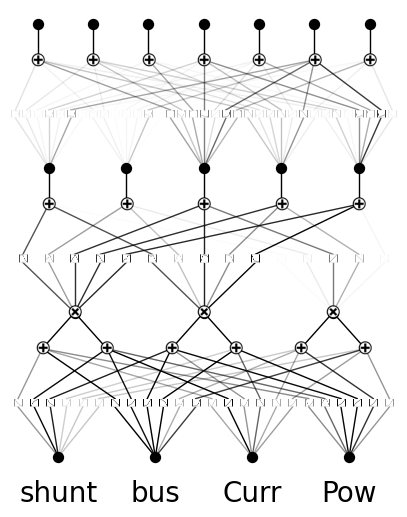

In [15]:
# train the model
model.fit(dataset, opt="Adam", steps=100, lr=1e-3)
model.plot(in_vars = [r'shunt', 'bus', 'Curr', 'Pow'],)

saving model version 0.2


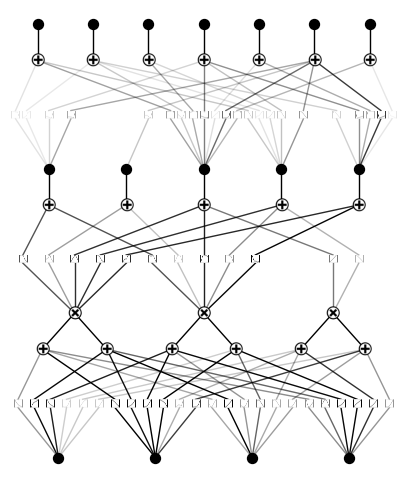

In [5]:
model = model.prune()
model.plot()

In [41]:
# model = model.prune_input()
# model.plot()

| train_loss: 2.80e-01 | test_loss: 4.44e-01 | reg: 2.68e+02 | : 100%|█| 200/200 [00:06<00:00, 32.65


saving model version 0.2


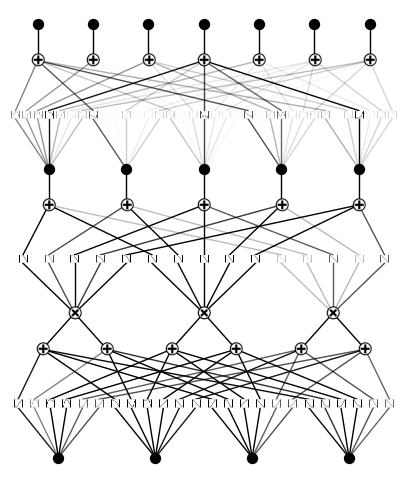

In [16]:
# continue training and replot
model.fit(dataset, opt="Adam", steps=200)
model.plot()

saving model version 0.5


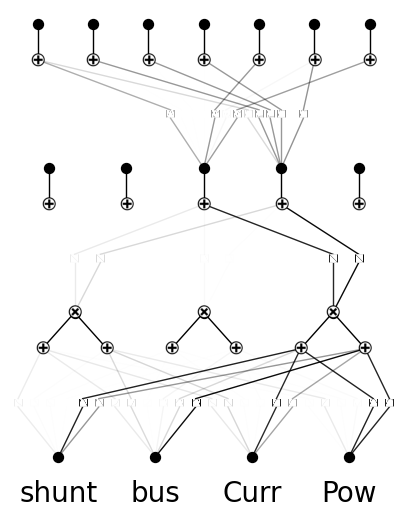

In [8]:
model.auto_swap()
model.plot(in_vars = [r'shunt', 'bus', 'Curr', 'Pow'],)
# plot_tree(model=model, x=dataset['test_input'], style='tree')
# print(torch.rand(100,6) * 2 - 1)

In [20]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

from kan.utils import ex_round

for formula in model.symbolic_formula()[0]:
    print(ex_round(formula, 4))

fixing (0,0,0) with sin, r2=0.9882389767662451, c=2
fixing (0,0,1) with x, r2=0.8124518774405499, c=1
fixing (0,0,2) with exp, r2=0.997132561408632, c=2
fixing (0,0,3) with x, r2=0.8243714563419131, c=1
fixing (0,0,4) with sin, r2=0.998999297945933, c=2
fixing (0,0,5) with x, r2=0.9581398642482974, c=1
fixing (0,1,0) with exp, r2=0.999735929863032, c=2
fixing (0,1,1) with sin, r2=0.9928603589375047, c=2
fixing (0,1,2) with x, r2=0.8737254843110439, c=1
fixing (0,1,3) with x, r2=0.9879434192770817, c=1
fixing (0,1,4) with x, r2=0.9619502095169851, c=1
fixing (0,1,5) with x, r2=0.9932715601522455, c=1
fixing (0,2,0) with sin, r2=0.999239407893589, c=2
fixing (0,2,1) with sin, r2=0.9980455572278195, c=2
fixing (0,2,2) with sqrt, r2=0.9977163161625923, c=2
fixing (0,2,3) with x, r2=0.9880208476910181, c=1
fixing (0,2,4) with sin, r2=0.999668993662789, c=2
fixing (0,2,5) with x, r2=0.9678055115838528, c=1
fixing (0,3,0) with sin, r2=0.9990237153726734, c=2
fixing (0,3,1) with sin, r2=0.9973

x range: [-1515.01 , 2146.09 ]
y range: [-11011.06 , 655.87 ]


(array(-1515.0089159),
 array(2146.08935405),
 array(-11011.06037698),
 array(655.87183012))

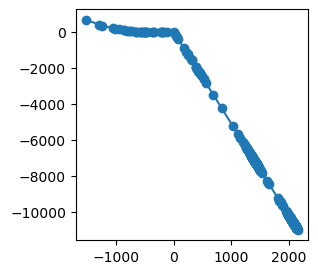

In [21]:
model.get_fun(1,0,1)
model.get_range(1,0,1)